# Libraries

In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('..')
import numpy as np
import scqubits as sq
from src.utilities import *
from src.fluxonium import calculate_CQPS_rate
import scipy.constants as const
import matplotlib.pyplot as plt
from src.fluxonium_manager import FluxoniumManager
# sq.set_units('GHz')
sq.settings.T1_DEFAULT_WARNING=False
from tqdm.notebook import tqdm
%matplotlib inline

In [2]:
bounds = {
    "small junction area (µm2)":    (0.01, 0.73/4),
    "hundreds of JJs":              (50,2000),
    }

optimal = FluxoniumManager()
optimal.minimizer(bounds=bounds)

In [34]:
optimal.get_optimization_results()

{'flux_0': FluxoniumResult(fluxonium=Fluxonium-----------| [Fluxonium_785]
                     | EJ: 3.435073388323686
                     | EC: 1.761507740950755
                     | EL: 0.05975780647517759
                     | flux: 0
                     | cutoff: 50
                     | truncated_dim: 6
                     |
                     | dim: 50
 , params = [0.03362331185454373, 847.974046556594], T2 = 14.6286 ms),
 'flux_0_5': FluxoniumResult(fluxonium=Fluxonium-----------| [Fluxonium_1270]
                     | EJ: 4.987617935128798
                     | EC: 2.0719294940855972
                     | EL: 0.1684206582026966
                     | flux: 0.5
                     | cutoff: 50
                     | truncated_dim: 6
                     |
                     | dim: 50
 , params = [0.04881998556833997, 300.87205162870475], T2 = 2.6681 ms)}

In [21]:
fluxonium_0:sq.Fluxonium = optimal.results['flux_0'].fluxonium
fluxonium_0_5:sq.Fluxonium = optimal.results['flux_0_5'].fluxonium

* phi = 0 : Small JJ area : 0.066 µm^2 and N = 523 JJs and EC = 2.864 EL = 0.096, EJ = 6.759
* phi = 1 : Small JJ area : 0.01 µm^2 and N = 642 JJs

Spectral data:   0%|          | 0/101 [00:00<?, ?it/s]

Spectral data:   0%|          | 0/101 [00:00<?, ?it/s]

Text(0.5, 1.0, 'flux = 0.5')

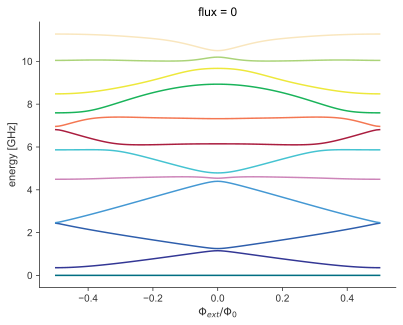

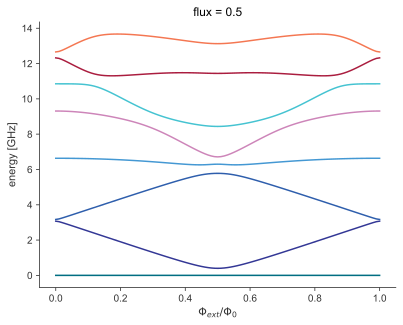

In [32]:
fig, ax = fluxonium_0.plot_evals_vs_paramvals(
    param_name='flux',
    param_vals=np.linspace(-0.5, 0.5, 101),
    evals_count=12,
    subtract_ground=True
    )
ax.set_title('flux = 0')

fig, ax = fluxonium_0_5.plot_evals_vs_paramvals(
    param_name='flux',
    param_vals=np.linspace(0, 1, 101),
    evals_count=8,
    subtract_ground=True
    )
ax.set_title('flux = 0.5')


In [33]:
fluxonium_0

Fluxonium(**{'EJ': 3.435073388323686, 'EC': 1.761507740950755, 'EL': 0.05975780647517759, 'flux': 0, 'cutoff': 50, 'truncated_dim': 6, 'id_str': 'Fluxonium_785', 'evals_method': None, 'evals_method_options': None, 'esys_method': None, 'esys_method_options': None})

In [ ]:
fluxonium_resonator_yaml = f"""
branches:
- ["JJ", 1,2, {self.optimal_fluxonium.EJ}, {self.optimal_fluxonium.EC}]
- ["L", 2,3, {self.optimal_fluxonium.EL/(1-beta)}]
# coupling inductance
- ["L", 1,3, {EL_shared}]
# jja antenna readout
- ["L", 3,4, {EL_only_resonator}]
- ["C", 4,1, {EC_jja_readout}]
"""

# Fluxonium-resonator

In [1167]:
beta_list = np.linspace(0.001,0.15, 50)
chi_list_beta = np.zeros_like(beta_list)
for i, beta in enumerate(beta_list):
    fluxonium_resonator = optimal.fluxonium_resonator_creator(resonator_frequency=5.5, beta=beta)
    subst_eigvals = fluxonium_resonator.eigenvals(evals_count=4) - fluxonium_resonator.eigenvals()[0]
    chi_list_beta[i] = ((subst_eigvals[3]-subst_eigvals[1])-(subst_eigvals[2]-subst_eigvals[0]))*1e3

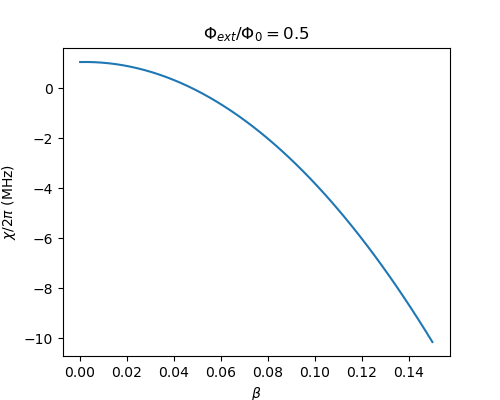

In [1169]:
plt.close('all')
fig,ax = plt.subplots(1,1, sharey=True, figsize = (5,4))
# ax[0].plot(resonator_freq_list,chi_list_res)
ax.set_title(rf'$\Phi_{{ext}}/\Phi_0 = 0.5$')
ax.plot(beta_list,chi_list_beta)
ax.set_xlabel(r'$\beta$')
ax.set_ylabel(r'$\chi/2\pi$ (MHz)')
# ax[2].plot(1/EL_res_list,chi_list_el)
plt.show()

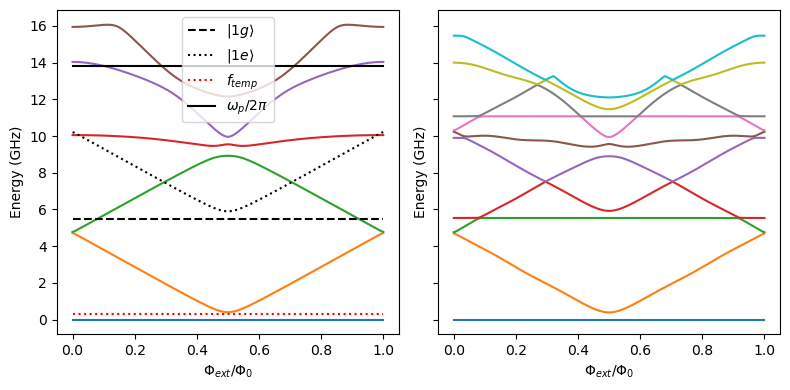

In [1191]:
optimal.flux_array = np.linspace(0,1, 301)
fig,ax = plt.subplots(1,2,sharey='row', figsize=(8,4))
optimal.plot_evals_vs_flux(resonator_freq=5.5,ax=ax[0], plasma_freq=13.8)
optimal.plot_evals_fluxonium_resonator_vs_flux(resonator_frequency=5.5,beta=0.10, evals_count=10, ax=ax[1])
fig.tight_layout()

In [1183]:
phi1_array = np.linspace(0,1,101)
fluxonium_resonator = optimal.fluxonium_resonator_creator(5.5, beta = 0.11)
eigensys_array = np.zeros((len(phi1_array),5))
for i, phi1 in enumerate(phi1_array):
    fluxonium_resonator.Φ1 = phi1
    eigvals = fluxonium_resonator.eigenvals(evals_count=5)
    eigensys_array[i] = eigvals

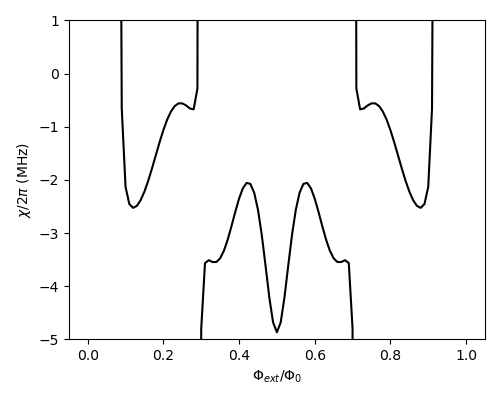

In [1186]:
plt.close('all')
%matplotlib widget
fig, ax = plt.subplots(1,1, figsize=(5,4))
# ax[0].plot(phi1_array,eigensys_array[:,1]-eigensys_array[:,0], label=r'$(E_{0e}-E_{0g})/h$')
# ax[0].plot(phi1_array,eigensys_array[:,5]-eigensys_array[:,0], label=r'$(E_{1g}-E_{0g})/h$')
ax.plot(phi1_array,1e3*((eigensys_array[:,3]-eigensys_array[:,1])-(eigensys_array[:,2]-eigensys_array[:,0])), color='k')
ax.plot(phi1_array,1e3*((eigensys_array[:,4]-eigensys_array[:,1])-(eigensys_array[:,2]-eigensys_array[:,0]))/2, color='k')
# ax.plot(phi1_array,1e3*((eigensys_array[:,5]-eigensys_array[:,1])-(eigensys_array[:,3]-eigensys_array[:,0]))/2, color='C0')

# ax[0].set_ylabel('Energy/h (GHz)')
# ax[0].set_xlabel(r'$\Phi_{ext}/\Phi_0$')
ax.set_xlabel(r'$\Phi_{ext}/\Phi_0$')
ax.set_ylabel(r'$\chi/2\pi$ (MHz)')
ax.set_ylim([-5,1])
# ax[0].legend()
fig.tight_layout()
plt.show()

# Fluxonium - Flux line

In [79]:
Phi0 = const.h/2/const.e
separation_array = np.linspace(15,25,10)
mutual_array = np.zeros_like(separation_array)
for i,separation in enumerate(tqdm(separation_array)):
    mutual_array[i] = calculate_mutual(loop_size=[12.4,63.6],
                    offset_position=[separation,13.2],
                    flux_line_length=90,
                    flux_line_width=7)/Phi0

  0%|          | 0/10 [00:00<?, ?it/s]

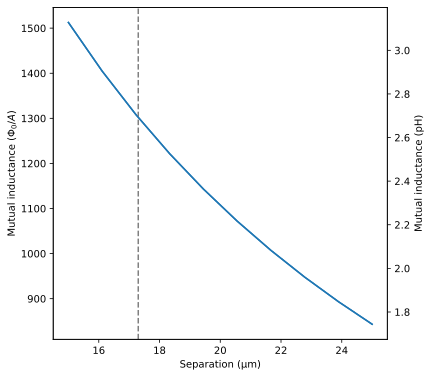

In [92]:
fig,ax = plt.subplots(1,1, figsize=(6,6))
ax.plot(separation_array,mutual_array)
ax.set_xlabel('Separation (µm)')
ax.axvline(17.3, linestyle='dashed', color='gray')
ax.set_ylabel(r'Mutual inductance $(\Phi_0/A)$')

ax2 = ax.twinx()
# Trazar el segundo conjunto de datos en el eje Y derecho
ax2.plot(separation_array, mutual_array*Phi0*1e12)
ax2.set_ylabel('Mutual inductance (pH)')
plt.show()